# Imports

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialise GPU

In [14]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loading and Pre-processing

In [15]:
class MIMICDataProcessor:
    def __init__(self, file_path, batch_size=64):
        self.file_path = file_path
        self.batch_size = batch_size
        self.scaler = StandardScaler()

        # Load and preprocess the data
        self.df = pd.read_csv(file_path)

        # Replace all missing values with 0
        self.df.fillna(0, inplace=True)

        # Features
        self.X = self.df[['upper_respiratory_infections', 'influenza_pneumonia', 'acute_lower_respiratory_infections', 'chronic_lower_respiratory_diseases',
                          'lung_diseases_due_to_external_agents', 'other_respiratory_diseases', 'InvasiveVent', 'SupplementalOxygen', 'HFNC',
                          'NonInvasiveVent', 'Tracheostomy', 'None', 'avg_uo_24hr', 'avg_creatinine_max', 'max_renal_uo_24hr', 'max_renal_creatinine_max',
                          'avg_pao2fio2ratio_novent', 'avg_pao2fio2ratio_vent', 'max_respiration_pao2fio2ratio_novent', 'max_respiration_pao2fio2ratio_vent', 'avg_gcs_min', 'max_cns_gcs_min',
                          'sofa_score', 'suspected_infection', 'one_vasopressor', 'multi_vasopressor']]

        # Vanilla Concepts
        self.C = self.df[['c_rsp_mod', 'c_rsp_svr', 'c_vent_low', 'c_vent_moderate', 'c_vent_high', 'c_max_renf_moderate', 'c_max_renf_severe',
                          'c_avg_renf_moderate', 'c_avg_renf_severe', 'c_max_respf_moderate', 'c_max_respf_severe', 'c_avg_respf_moderate',
                          'c_avg_respf_severe', 'c_max_cnsf_moderate', 'c_max_cnsf_severe', 'c_avg_cnsf_moderate', 'c_avg_cnsf_severe',
                          'c_sepsis3', 'c_shock']]

        # Additional LLM Concepts
        self.LLM_C = self.df[['ards_detected', 'aspiration_detected', 'bilateral_infiltrates_detected', 'cardiac_arrest_detected',
                          'cardiac_failure_detected', 'pancreatitis_detected', 'pneumonia_detected', 'trali_detected']]

        # Label
        self.Y = self.df['ARDS']

        # Convert to tensors
        self.X_tensor = torch.tensor(self.X.values, dtype=torch.float32)
        self.C_tensor = torch.tensor(self.C.values, dtype=torch.float32)
        self.LLM_C_tensor = torch.tensor(self.LLM_C.values, dtype=torch.float32)
        self.Y_tensor = torch.tensor(self.Y.values, dtype=torch.float32)

        # Normalize the features
        self.X_scaled = self.scaler.fit_transform(self.X)
        self.X_tensor_scaled = torch.tensor(self.X_scaled, dtype=torch.float32)

    def get_vanilla_concepts(self):
      return self.C.columns.tolist()

    class MIMICDataset(Dataset):
        def __init__(self, x, c, llm_c, y):
            self.x = x
            self.c = c
            self.llm_c = llm_c
            self.y = y

        def __len__(self):
            return len(self.y)

        def __getitem__(self, idx):
            return self.x[idx], self.c[idx], self.llm_c[idx], self.y[idx]


    def create_dataloaders(self):
        # Split the data into temporary (80%) and test (20%) sets
        X_temp, X_test, C_temp, C_test, LLM_C_temp, LLM_C_test, Y_temp, Y_test = train_test_split(
            self.X_tensor_scaled, self.C_tensor, self.LLM_C_tensor, self.Y_tensor, test_size=0.20, random_state=42)

        # Further split the temporary data into training (75% of temporary) and validation (25% of temporary) sets
        X_train, X_val, C_train, C_val, LLM_C_train, LLM_C_val, Y_train, Y_val = train_test_split(
            X_temp, C_temp, LLM_C_temp, Y_temp, test_size=0.25, random_state=42)

        train_dataset = self.MIMICDataset(X_train, C_train, LLM_C_train, Y_train)
        val_dataset = self.MIMICDataset(X_val, C_val, LLM_C_val, Y_val)
        test_dataset = self.MIMICDataset(X_test, C_test, LLM_C_test, Y_test)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader, test_loader

# Model

In [16]:
class MultiLabelNN(nn.Module):
    def __init__(self, num_features, num_labels):
        super(MultiLabelNN, self).__init__()
        self.layer1 = nn.Linear(num_features, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, num_labels)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.sigmoid(self.output_layer(x))  # Sigmoid activation to output probabilities for each label
        return x

class CombinedNN(nn.Module):
    def __init__(self, num_features, num_vanilla_concepts, num_llm_concepts, num_labels):
        super(CombinedNN, self).__init__()
        self.vanilla_c_predictor = MultiLabelNN(num_features, num_vanilla_concepts)
        self.label_predictor = MultiLabelNN(num_vanilla_concepts + num_llm_concepts, num_labels)

    def forward(self, x, llm_c):
        vanilla_c = self.vanilla_c_predictor(x)
        combined_c = torch.cat((vanilla_c, llm_c), dim=1)
        y_pred = self.label_predictor(combined_c)
        return y_pred, vanilla_c

# Training

In [17]:
def train_combined_model(x_size, vanilla_c_size, llm_c_size, y_size, learning_rate, epochs, train_loader, val_loader, weight_decay=0.01):
    torch.manual_seed(25)

    model = CombinedNN(num_features=x_size, num_vanilla_concepts=vanilla_c_size, num_llm_concepts=llm_c_size, num_labels=y_size).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    epochs_count = []
    train_loss_values, val_loss_values = [], []
    vanilla_c_predictions, label_predictions = [], []
    vanilla_c_val_predictions, label_val_predictions = [], []
    ground_truth_val_vanilla_c, ground_truth_val_label = [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")  # Print current epoch
        epochs_count.append(epoch)

        # Training Loop
        model.train()
        running_loss = 0.0

        for i, batch in enumerate(train_loader):
            x, vanilla_c, llm_c, y = batch
            x, vanilla_c, llm_c, y = x.to(device), vanilla_c.to(device), llm_c.to(device), y.to(device)

            # Forward pass
            optimizer.zero_grad()
            y_pred, vanilla_c_pred = model(x, llm_c)
            vanilla_c_predictions.append(vanilla_c_pred.detach().cpu().numpy())
            label_predictions.append(y_pred.detach().cpu().numpy())
            loss = criterion(y_pred, y.unsqueeze(1).float())

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss value
            running_loss += loss.item()

        train_loss_values.append(running_loss / len(train_loader))

        # Validation Loop
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for x, vanilla_c, llm_c, y in val_loader:
                x, vanilla_c, llm_c, y = x.to(device), vanilla_c.to(device), llm_c.to(device), y.to(device)

                ground_truth_val_vanilla_c.append(vanilla_c.cpu())
                ground_truth_val_label.append(y.cpu())

                # Forward pass through model
                y_pred, vanilla_c_pred = model(x, llm_c)
                vanilla_c_val_predictions.append(vanilla_c_pred.detach().cpu().numpy())
                label_val_predictions.append(y_pred.detach().cpu().numpy())
                loss = criterion(y_pred, y.unsqueeze(1).float())

                # Accumulate loss value
                running_val_loss += loss.item()

        val_loss_values.append(running_val_loss / len(val_loader))

        scheduler.step()

    return model, epochs_count, train_loss_values, val_loss_values, vanilla_c_predictions, label_predictions, vanilla_c_val_predictions, label_val_predictions, ground_truth_val_vanilla_c, ground_truth_val_label

In [18]:
# Specify Parameters
x_size = 26
vanilla_c_size = 19
llm_c_size = 8
y_size = 1
learning_rate = 0.01
epochs = 60
weight_decay = 0.01

# Load Data
file_path = '/content/augmented-ards-data.csv'
data_processor = MIMICDataProcessor(file_path, batch_size=64)
train_loader, val_loader, test_loader = data_processor.create_dataloaders()

regularised_model, epochs_count, train_loss_values, val_loss_values, vanilla_c_predictions, label_predictions, vanilla_c_val_predictions, label_val_predictions, ground_truth_val_vanilla_c, ground_truth_val_label = train_combined_model(x_size, vanilla_c_size, llm_c_size, y_size, learning_rate, epochs, train_loader, val_loader, weight_decay)

Epoch 1/60
Epoch 2/60
Epoch 3/60
Epoch 4/60
Epoch 5/60
Epoch 6/60
Epoch 7/60
Epoch 8/60
Epoch 9/60
Epoch 10/60
Epoch 11/60
Epoch 12/60
Epoch 13/60
Epoch 14/60
Epoch 15/60
Epoch 16/60
Epoch 17/60
Epoch 18/60
Epoch 19/60
Epoch 20/60
Epoch 21/60
Epoch 22/60
Epoch 23/60
Epoch 24/60
Epoch 25/60
Epoch 26/60
Epoch 27/60
Epoch 28/60
Epoch 29/60
Epoch 30/60
Epoch 31/60
Epoch 32/60
Epoch 33/60
Epoch 34/60
Epoch 35/60
Epoch 36/60
Epoch 37/60
Epoch 38/60
Epoch 39/60
Epoch 40/60
Epoch 41/60
Epoch 42/60
Epoch 43/60
Epoch 44/60
Epoch 45/60
Epoch 46/60
Epoch 47/60
Epoch 48/60
Epoch 49/60
Epoch 50/60
Epoch 51/60
Epoch 52/60
Epoch 53/60
Epoch 54/60
Epoch 55/60
Epoch 56/60
Epoch 57/60
Epoch 58/60
Epoch 59/60
Epoch 60/60


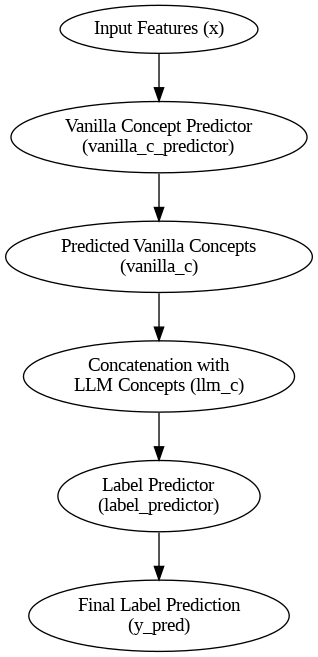

In [19]:
from graphviz import Digraph
from IPython.display import Image

# Create the graph
dot = Digraph()

dot.node('A', 'Input Features (x)')
dot.node('B', 'Vanilla Concept Predictor\n(vanilla_c_predictor)')
dot.node('C', 'Predicted Vanilla Concepts\n(vanilla_c)')
dot.node('D', 'Concatenation with\nLLM Concepts (llm_c)')
dot.node('E', 'Label Predictor\n(label_predictor)')
dot.node('F', 'Final Label Prediction\n(y_pred)')

dot.edges(['AB', 'BC', 'CD', 'DE', 'EF'])

# Render the graph to a PNG file and display it
dot.render('flowchart', format='png')

# Display the image
Image(filename='flowchart.png')


# Plotting Loss


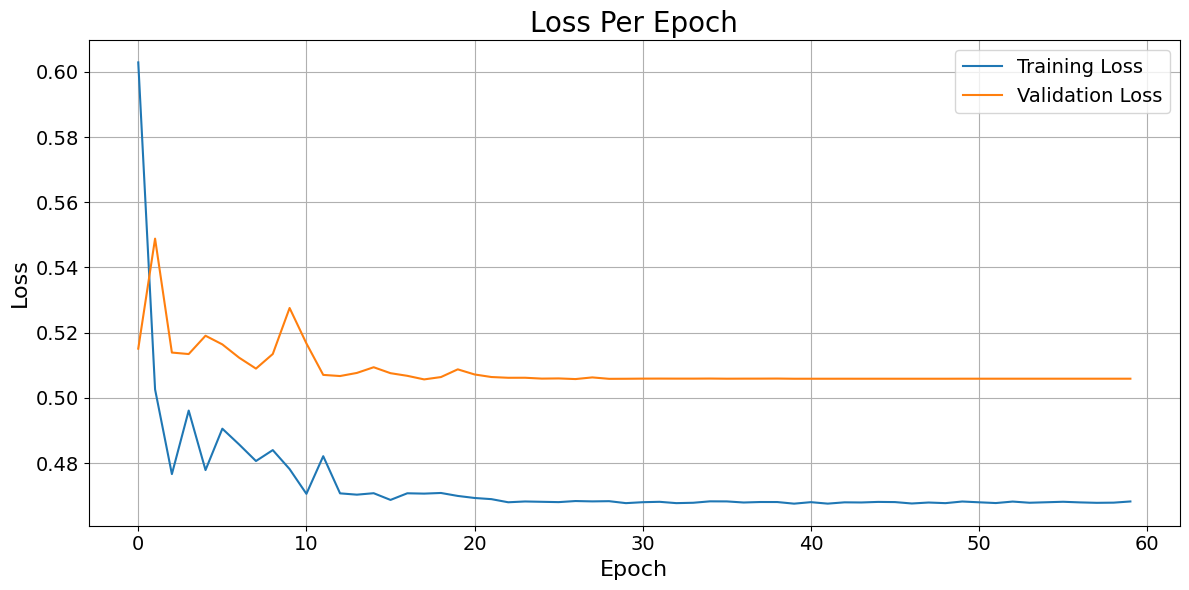

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, train_loss_values, label='Training Loss')
plt.plot(epochs_count, val_loss_values, label='Validation Loss')
plt.title('Loss Per Epoch', fontsize=20)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig('ards-enhanced-seq.png')
plt.show()

# Validation Evaluation

In [21]:
def evaluate_concept_predictor(ground_truth_c, x_to_c_predictions, concept_labels):
    results = []
    precisions = []
    recalls = []
    f1_scores = []
    aucs = []
    accuracies = []

    for i, label in enumerate(concept_labels):
        true_values = torch.cat([c[:, i] if isinstance(c, torch.Tensor) else torch.tensor(c[:, i]) for c in ground_truth_c]).numpy()
        predicted_values = torch.cat([c[:, i] if isinstance(c, torch.Tensor) else torch.tensor(c[:, i]) for c in x_to_c_predictions]).numpy()

        predicted_classes = (predicted_values > 0.5).astype(int)  # Convert probabilities to binary classes

        precision = precision_score(true_values, predicted_classes, zero_division=0)
        recall = recall_score(true_values, predicted_classes, zero_division=0)
        f1 = f1_score(true_values, predicted_classes, zero_division=0)
        # Check if both classes are present in true_values before calculating AUC
        if len(np.unique(true_values)) == 2:
            auc = roc_auc_score(true_values, predicted_values)  # Use predicted probabilities for AUC
        else:
            auc = None
        accuracy = accuracy_score(true_values, predicted_classes)

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        aucs.append(auc if auc is not None else 0)  # Use 0 or another value for averaging
        accuracies.append(accuracy)

        results.append({
            "Label": label,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "AUC": auc,
            "Accuracy": accuracy
        })

    # Calculate the average values for each metric, excluding None values for AUC
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1_scores)
    avg_auc = np.mean([auc for auc in aucs if auc is not None])
    avg_accuracy = np.mean(accuracies)

    # Append the average values to the results
    results.append({
        "Label": "Average",
        "Precision": avg_precision,
        "Recall": avg_recall,
        "F1 Score": avg_f1,
        "AUC": avg_auc,
        "Accuracy": avg_accuracy
    })

    return pd.DataFrame(results)


# Label Predictor Evaluation
def evaluate_label_predictor(ground_truth_y, predicted_y):
    true_values = np.concatenate(ground_truth_y)
    predicted_values = np.concatenate(predicted_y).squeeze()

    predicted_classes = (predicted_values > 0.5).astype(int)

    precision = precision_score(true_values, predicted_classes)
    recall = recall_score(true_values, predicted_classes)
    f1 = f1_score(true_values, predicted_classes)
    auc = roc_auc_score(true_values, predicted_classes)
    accuracy = accuracy_score(true_values, predicted_classes)

    results = {
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc,
        "Accuracy": accuracy
    }
    return pd.DataFrame(results, index=["Metrics"])

In [22]:
# Evaluate the concept predictor
vanilla_concept_list = data_processor.C.columns.tolist()
concept_test_results = evaluate_concept_predictor(ground_truth_val_vanilla_c, vanilla_c_val_predictions, vanilla_concept_list)
print("\nValidation Concept Predictor Results:")
print(concept_test_results)

# Evaluate the label predictor
label_test_results = evaluate_label_predictor(ground_truth_val_label, label_val_predictions)
print("\nValidation Label Predictor Results:")
print(label_test_results)


Validation Concept Predictor Results:
                   Label  Precision    Recall  F1 Score       AUC  Accuracy
0              c_rsp_mod   0.000000  0.000000  0.000000  0.500003  0.225248
1              c_rsp_svr   0.188119  0.016667  0.030620  0.500082  0.801485
2             c_vent_low   0.767327  0.016667  0.032625  0.499993  0.241584
3        c_vent_moderate   0.000000  0.000000  0.000000  0.500159  0.868812
4            c_vent_high   0.997525  0.766667  0.866991  0.500327  0.765347
5    c_max_renf_moderate   0.329208  0.750000  0.457569  0.499958  0.414604
6      c_max_renf_severe   0.000000  0.000000  0.000000  0.500027  0.514851
7    c_avg_renf_moderate   0.000000  0.000000  0.000000  0.500007  0.891089
8      c_avg_renf_severe   0.000000  0.000000  0.000000  0.499923  0.861386
9   c_max_respf_moderate   0.000000  0.000000  0.000000  0.500066  0.957921
10    c_max_respf_severe   0.957921  0.783333  0.861875  0.499970  0.759488
11  c_avg_respf_moderate   0.000000  0.000000  0.

# Testing Evaluation

In [23]:
# Function to test the model and gather predictions
def test_combined_model(model, test_loader):
    model.eval()
    criterion = nn.BCELoss()

    running_loss = 0.0
    all_y_true = []
    all_y_pred = []
    all_vanilla_c_true = []
    all_vanilla_c_pred = []

    with torch.no_grad():
        for x, vanilla_c, llm_c, y in test_loader:
            x, vanilla_c, llm_c, y = x.to(device), vanilla_c.to(device), llm_c.to(device), y.to(device)

            y_pred, vanilla_c_pred = model(x, llm_c)
            loss = criterion(y_pred, y.unsqueeze(1).float())
            running_loss += loss.item()

            all_y_true.append(y.cpu().numpy())
            all_y_pred.append(y_pred.cpu().numpy())
            all_vanilla_c_true.append(vanilla_c.cpu().numpy())
            all_vanilla_c_pred.append(vanilla_c_pred.cpu().numpy())

    average_loss = running_loss / len(test_loader)
    print(f'Test Loss: {average_loss:.4f}')

    return all_y_true, all_y_pred, all_vanilla_c_true, all_vanilla_c_pred

In [24]:
# Test the model and gather predictions
y_true, y_pred, vanilla_c_true, vanilla_c_pred = test_combined_model(regularised_model, test_loader)

# Evaluate the concept predictor
concept_labels = data_processor.C.columns.tolist()
concept_test_results = evaluate_concept_predictor(vanilla_c_true, vanilla_c_pred, concept_labels)
print("\nTest Concept Predictor Results:")
print(concept_test_results)

# Evaluate the label predictor
label_test_results = evaluate_label_predictor(y_true, y_pred)
print("\nTest Label Predictor Results:")
print(label_test_results)

Test Loss: 0.5475

Test Concept Predictor Results:
                   Label  Precision    Recall  F1 Score  AUC  Accuracy
0              c_rsp_mod   0.000000  0.000000  0.000000  0.5  0.251852
1              c_rsp_svr   0.000000  0.000000  0.000000  0.5  0.797531
2             c_vent_low   0.000000  0.000000  0.000000  0.5  0.264198
3        c_vent_moderate   0.000000  0.000000  0.000000  0.5  0.866667
4            c_vent_high   0.995062  1.000000  0.997525  0.5  0.995062
5    c_max_renf_moderate   0.328395  1.000000  0.494424  0.5  0.328395
6      c_max_renf_severe   0.000000  0.000000  0.000000  0.5  0.543210
7    c_avg_renf_moderate   0.000000  0.000000  0.000000  0.5  0.930864
8      c_avg_renf_severe   0.000000  0.000000  0.000000  0.5  0.876543
9   c_max_respf_moderate   0.000000  0.000000  0.000000  0.5  0.950617
10    c_max_respf_severe   0.950617  1.000000  0.974684  0.5  0.950617
11  c_avg_respf_moderate   0.000000  0.000000  0.000000  0.5  0.760494
12    c_avg_respf_severe  